In [50]:
# read plain mnist as training
# test on morph mnist

In [51]:
# In this code we load the original MNIST data, modify it in various ways, and save the augmented data

In [125]:
import pandas as pd
import numpy as np
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as T

from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from matplotlib import cm

from scipy.ndimage import gaussian_filter

In [112]:
# Data folder location
datafolder = 'C:\\Users\\joele\\OneDrive\\CMIC hackathon\\data\\test'

# Load original data as csv file, and save it as npy file
images_csv = pd.read_csv(os.path.join(datafolder, 'mnist_test.csv'))

# Visualize data
print(images_csv.shape)
images_csv.head()

(10000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
images = images_csv.iloc[:,1:]
# The numbers the digits correspond to
values = images_csv.iloc[:,0]
images = images.values / 255.
images = np.reshape(images, (-1, 1, 28, 28))

np.save(os.path.join(datafolder, 'raw.npy'), images)

In [114]:
# Display the few first instances of data.
# Assumes image is in format n*1*a*b
def display(rows, columns, images, values=[], predictions=[]):
    fig = plt.figure(figsize=(9, 11))

    ax = []

    for i in range(columns*rows):
        img = images[i,0,:,:]
        ax.append(fig.add_subplot(rows, columns, i+1))
        
        title = ""
        
        if(len(values) == 0):
            title = "Pred:" + str(predictions[i])
        elif(len(predictions) == 0):
            title = "Value:" + str(values[i])
        elif(len(values) != 0 and len(predictions) != 0):
            title = "Value:" + str(values[i]) + "\nPred:" + str(predictions[i])
        
        ax[-1].set_title(title)  # set title
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)

    plt.show()

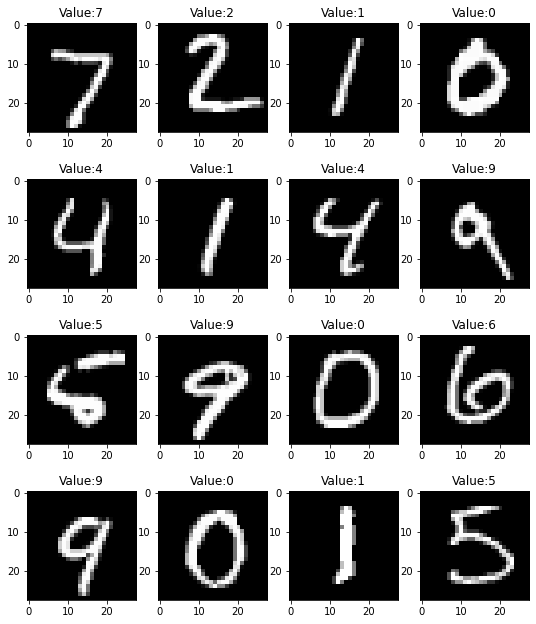

In [115]:
r = 4
c = 4

display(rows=r, columns=c, images=images, values=values, predictions=[])

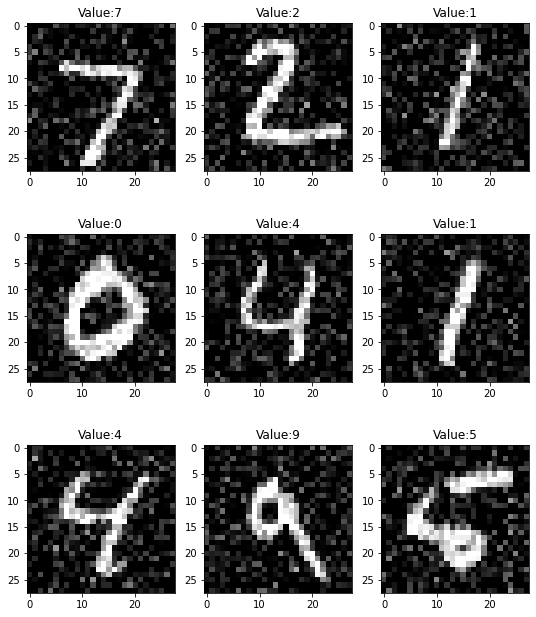

In [142]:
# Create slightly noisy images
noise = np.random.normal(0, 0.2, images.shape)
mask_overflow_upper = images + noise >= 1.0
mask_overflow_lower = images + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_noisy2 = images + noise
display(rows=r, columns=c, images=images_noisy2, values=values, predictions=[])

# Save the slightly noisy images
np.save(os.path.join(datafolder, 'noisy2.npy'), images_noisy2)

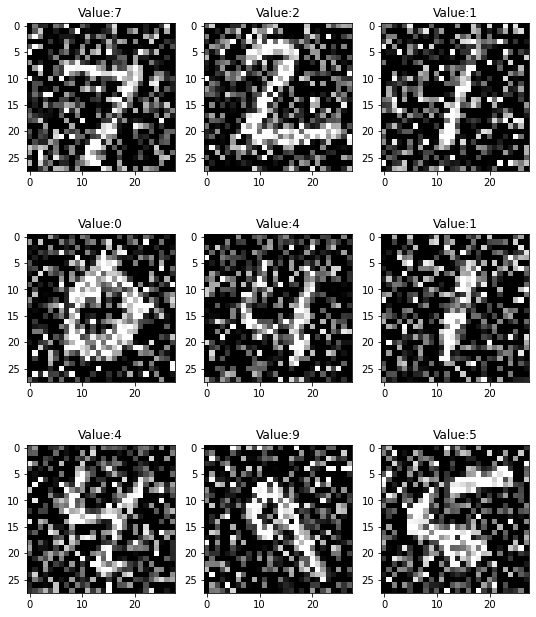

In [143]:
# Create noisy images
noise = np.random.normal(0, 0.5, images.shape)
mask_overflow_upper = images + noise >= 1.0
mask_overflow_lower = images + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_noisy5 = images + noise
display(rows=r, columns=c, images=images_noisy5, values=values, predictions=[])

# Save the noisy images
np.save(os.path.join(datafolder, 'noisy5.npy'), images_noisy5)

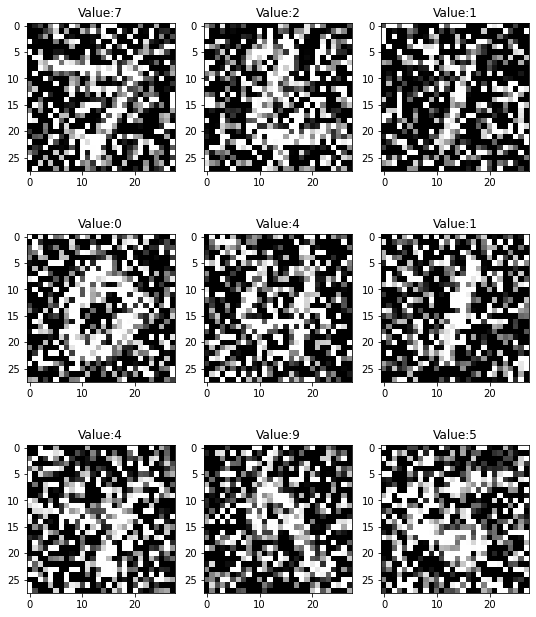

In [144]:
# Create very noisy images
noise = np.random.normal(0, 1, images.shape)
mask_overflow_upper = images + noise >= 1.0
mask_overflow_lower = images + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_noisy10 = images + noise
display(rows=r, columns=c, images=images_noisy10, values=values, predictions=[])

# Save the very noisy images
np.save(os.path.join(datafolder, 'noisy10.npy'), images_noisy5)

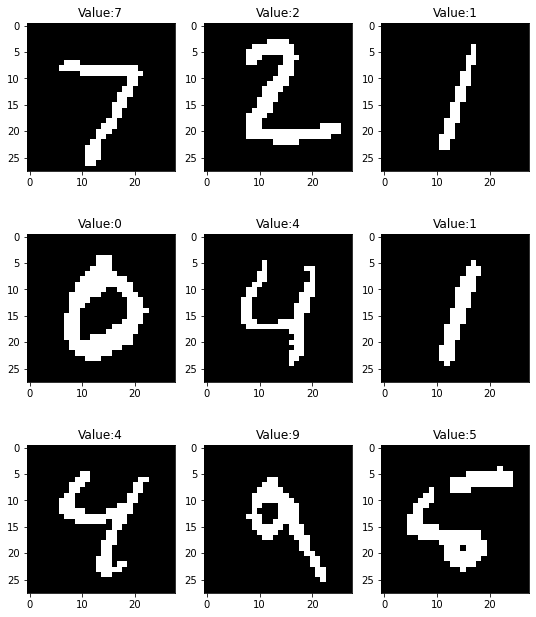

In [145]:
# Segment the images to 0's and 1's (labels)
labels = np.zeros_like(images)
labels[images >= 0.5] = 1
labels[images < 0.5] = 0

display(rows=r, columns=c, images=labels, values=values, predictions=[])

# Save the segmented images
np.save(os.path.join(datafolder, 'labels.npy'), labels)

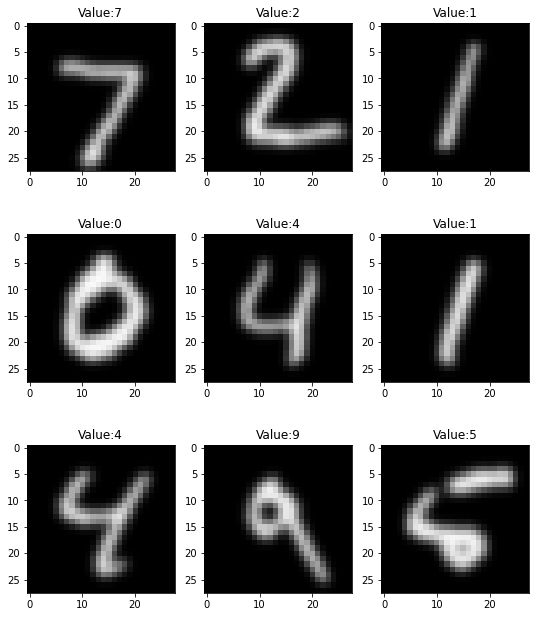

In [146]:
# Blur the images a little
blurred9 = gaussian_filter(images, sigma=(0, 0, 0.9, 0.9))

display(rows=r, columns=c, images=blurred9, values=values, predictions=[])

# Save the blurry images
np.save(os.path.join(datafolder, 'blurred9.npy'), blurred9)

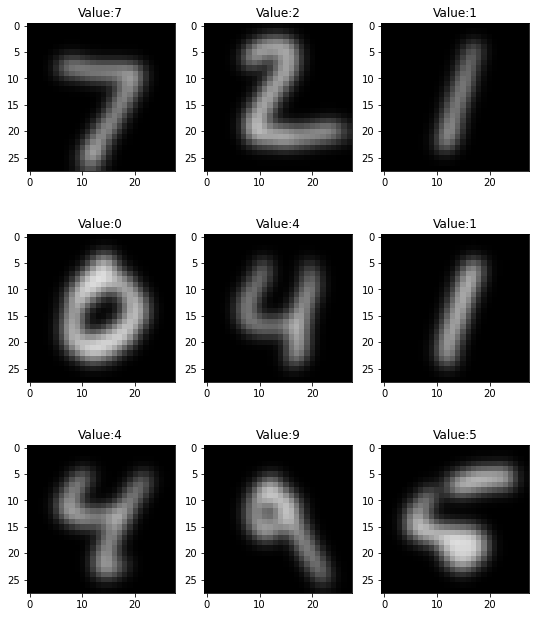

In [147]:
# Blur the images more
blurred15 = gaussian_filter(images, sigma=(0, 0, 1.5, 1.5))

display(rows=r, columns=c, images=blurred15, values=values, predictions=[])

# Save the blurrier images
np.save(os.path.join(datafolder, 'blurred15.npy'), blurred15)

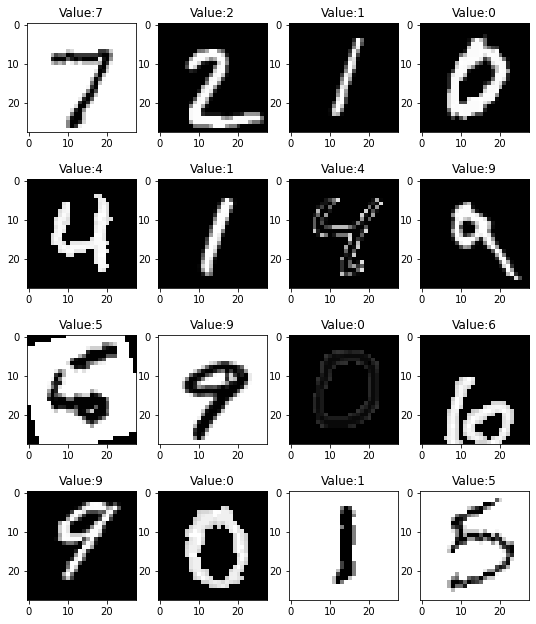

In [171]:
# Use torchvision's auto augmentation policy on the data
# Policies can be chosen from IMAGENET, CIFAR10 and SVHN.
# Rotation, shearing, shifting, edge-filtering,
# inversion of colors, adjusting contrast etc.

# Make images have three channels
autoaugmented = np.tile(images, (1,3,1,1))

# Convert images from numpy arrays to tensors
autoaugmented = torch.tensor(np.uint8(autoaugmented*255))

policy = T.AutoAugmentPolicy.SVHN
augmenter = T.AutoAugment(policy)

for i in range(0, autoaugmented.shape[0]):
    autoaugmented[i,:,:,:] = augmenter(autoaugmented[i,:,:,:])

# Convert images back to single-channel numpy arrays
autoaugmented = np.double(autoaugmented.numpy())/255
autoaugmented = np.reshape(autoaugmented[:,1,:,:], (images.shape[0],1,images.shape[2],images.shape[3]))

display(rows=r, columns=c, images=autoaugmented, values=values, predictions=[])

# Save the autoaugmented images
np.save(os.path.join(datafolder, 'autoaugmented.npy'), autoaugmented)

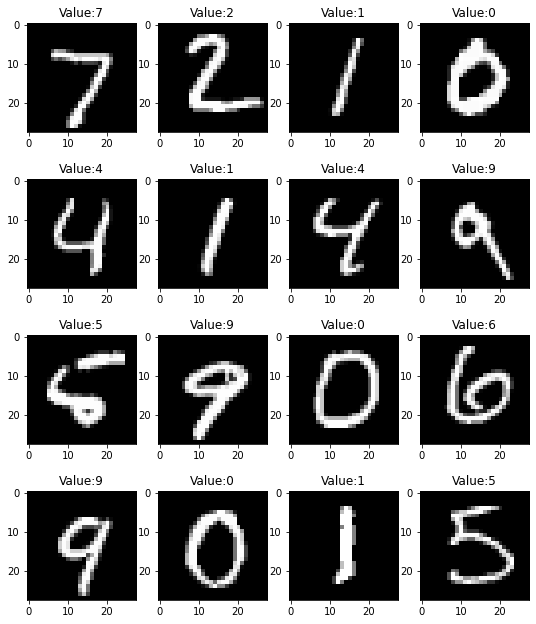

In [72]:
# These should be the original images
display(rows=r, columns=c, images=images, values=values, predictions=[])